In [54]:
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [2]:
news = pd.read_csv('./en_interim_01_05_DV_IN_with_full_texts.csv', index_col=False)

In [3]:
news_df = news[["DATEADDED","SOURCEURL","title", "text"]]

In [4]:
nlp = spacy.load('en_core_web_sm')
def normalize_text(text):
  text = str(text)
  tm1 = re.sub('<pre>.*?</pre>', '', text, flags=re.DOTALL)
  tm2 = re.sub('<code>.*?</code>', '', tm1, flags=re.DOTALL)
  tm3 = re.sub('<[^>]+>©', '', tm1, flags=re.DOTALL)
  return tm3.replace("\n", "")

news_text = news_df[news_df.text != "Empty"]

news_text['text_norm'] = news_text['text'].apply(normalize_text)

In [6]:
punctuations = '!"#$%&\'()*+,-/:;<=>?@[\\]^_`{|}~©'
def cleanup_text(docs, logging=False):
    texts = []
    doc = nlp(docs, disable=['parser', 'ner'])
    tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
    tokens = [tok for tok in tokens if tok not in stop_words and tok not in punctuations]
    tokens = ' '.join(tokens)
    texts.append(tokens)
    return pd.Series(texts)
news_text['full_text'] = news_text['text_norm'].apply(lambda x: cleanup_text(x, False))

In [8]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = ' '.join(re.sub("(\w+:\/\/\S+)", " ", sent).split()) # removal of address
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove apostrophe
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  
        
# Convert to list
data = news_text.full_text.values.tolist()
data_words = list(sent_to_words(data))

[['surat', 'kill', 'dishit', 'jariwala', 'wife', 'two', 'set', 'walk', 'free', 'surat', 'news', 'times', 'indiaenglish', 'epaper', 'homecitysmart', 'timesgood', 'newstoi', 'fact', 'checkgood', 'editorialset', 'reviewsphotos', 'etimes', 'musicbeauty', 'tvtvtv', 'newstv', 'listingstimes', 'nowet', 'nowzoom', 'search', 'fitnesstoday', 'dealsfood', 'beverageshome', 'decor', 'newstrending', 'universitytoi', 'studenttimes', 'study', 'transitsrituals', 'newstech', 'photoslatest', 'gadgetsgadgets', 'newssurat', 'newssurat', 'kill', 'dishit', 'jariwala', 'wife', 'two', 'set', 'walk', 'freethis', 'story', 'january', 'surat', 'kill', 'dishit', 'jariwala', 'wife', 'two', 'set', 'walk', 'freetnn', 'update', 'jan', 'istvelsee', 'dishit', 'jariwala', 'happy', 'timessurat', 'huge', 'setback', 'police', 'sensational', 'dishit', 'jariwala', 'murder', 'case', 'three', 'accuse', 'include', 'wife', 'acquit', 'local', 'court', 'tuesday', 'three', 'half', 'year', 'brutal', 'crime', 'court', 'give', 'benefit'

In [9]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

In [15]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

In [16]:
pprint(lda_model.print_topics())

[(0,
  '0.052*"woman" + 0.013*"child" + 0.010*"violence" + 0.009*"work" + '
  '0.007*"country" + 0.006*"government" + 0.006*"indian" + 0.005*"people" + '
  '0.005*"female" + 0.005*"provide"'),
 (1,
  '0.015*"time" + 0.014*"help" + 0.011*"share" + 0.011*"life" + 0.010*"actor" '
  '+ 0.010*"family" + 0.010*"love" + 0.009*"year" + 0.008*"people" + '
  '0.008*"find"'),
 (2,
  '0.018*"legal" + 0.016*"rape" + 0.013*"prison" + 0.012*"date" + 0.012*"plea" '
  '+ 0.011*"inmate" + 0.010*"law" + 0.010*"consent" + 0.010*"page" + '
  '0.009*"file"'),
 (3,
  '0.022*"case" + 0.016*"police" + 0.014*"year" + 0.014*"day" + '
  '0.014*"lockdown" + 0.013*"covid" + 0.013*"news" + 0.009*"flight" + '
  '0.009*"old" + 0.009*"woman"'),
 (4,
  '0.041*"student" + 0.037*"bride" + 0.032*"worker" + 0.021*"job" + '
  '0.020*"orissapost" + 0.020*"orissapost_com" + 0.019*"wedding" + '
  '0.018*"post" + 0.018*"school" + 0.016*"thing"')]


In [31]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.7218,"case, police, year, day, lockdown, covid, news...","[set, walk, set, walk, freethis, story, surat,..."
1,1,0.0,0.2000,"woman, child, violence, work, country, governm...",[]
2,2,3.0,0.6129,"case, police, year, day, lockdown, covid, news...","[protest, family, victim, free, hard, confirm,..."
3,3,0.0,0.4678,"woman, child, violence, work, country, governm...","[young, woman, news, world, world, test_vs_sou..."
4,4,3.0,0.5180,"case, police, year, day, lockdown, covid, news...","[guilty, rape, murder, guilty, rape, guilty, r..."
5,5,0.0,0.5177,"woman, child, violence, work, country, governm...","[young, woman, win, flood, year, eventful, fin..."
6,6,3.0,0.5212,"case, police, year, day, lockdown, covid, news...","[dead, kill, result, businessman, wife, daught..."
7,7,3.0,0.5063,"case, police, year, day, lockdown, covid, news...","[daughter, find, dead, inside, car, result, bu..."
8,8,3.0,0.9625,"case, police, year, day, lockdown, covid, news...","[old, woman, private, part, rape, news, dofamo..."
9,9,3.0,0.3956,"case, police, year, day, lockdown, covid, news...","[young, woman, eventful, portalhomee, portal, ..."


In [32]:
df_dominant_topic.shape

(6708, 5)

In [33]:
news_text['Topic_lda'] = df_dominant_topic['Dominant_Topic']

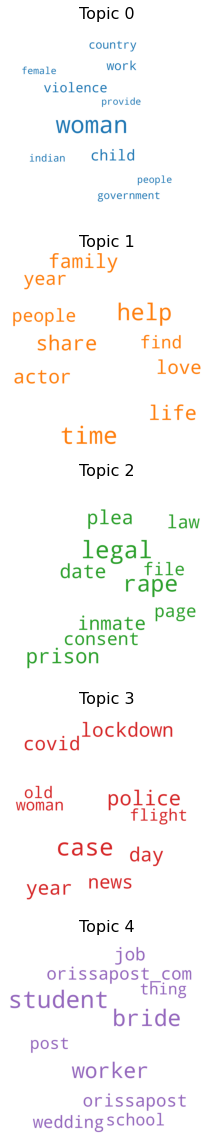

In [42]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=2500,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)
fig, axes = plt.subplots(5, 1, figsize=(16,16), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [43]:
lda_dataset= news_text[(news_text['Topic_lda']==0) | (news_text['Topic_lda']==2)]

In [44]:
lda_dataset.shape

(1376, 7)

# NMF

In [66]:
# Train the model on the corpus.
nmf = gensim.models.nmf.Nmf(corpus=corpus,
                                   id2word=id2word,
                                   num_topics=5, 
                                   random_state=100,
                                   chunksize=10)

In [67]:
pprint(nmf.print_topics())

[(0,
  '0.062*"student" + 0.052*"orissapost_com" + 0.051*"orissapost" + '
  '0.030*"police" + 0.026*"com" + 0.025*"post" + 0.017*"school" + 0.013*"call" '
  '+ 0.009*"protest" + 0.008*"public"'),
 (1,
  '0.028*"day" + 0.024*"case" + 0.023*"protest" + 0.022*"covid" + '
  '0.018*"government" + 0.014*"lockdown" + 0.013*"new" + 0.010*"news" + '
  '0.010*"ago" + 0.010*"free"'),
 (2,
  '0.016*"year" + 0.009*"new" + 0.008*"time" + 0.008*"home" + 0.008*"day" + '
  '0.007*"people" + 0.007*"help" + 0.007*"family" + 0.006*"lockdown" + '
  '0.006*"find"'),
 (3,
  '0.074*"woman" + 0.008*"work" + 0.007*"violence" + 0.006*"man" + '
  '0.004*"officer" + 0.004*"country" + 0.004*"domestic" + 0.004*"government" + '
  '0.004*"police" + 0.004*"give"'),
 (4,
  '0.042*"case" + 0.037*"rape" + 0.022*"convict" + 0.021*"police" + '
  '0.020*"court" + 0.015*"year" + 0.015*"victim" + 0.013*"accuse" + '
  '0.009*"news" + 0.009*"murder"')]


In [110]:
def format_nmf_topics_sentences(model=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(model[corpus]):
        row = row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = nmf.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


In [111]:
df_topic_sents_keywords_nmf = format_nmf_topics_sentences(model=nmf, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic_nmf = df_topic_sents_keywords_nmf.reset_index()
df_dominant_topic_nmf.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic_nmf.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4.0,0.6682,"case, rape, convict, police, court, year, vict...","[set, walk, set, walk, freethis, story, surat,..."
1,1,1.0,0.4548,"day, case, protest, covid, government, lockdow...",[]
2,2,3.0,0.3791,"woman, work, violence, man, officer, country, ...","[protest, family, victim, free, hard, confirm,..."
3,3,4.0,0.3465,"case, rape, convict, police, court, year, vict...","[young, woman, news, world, world, test_vs_sou..."
4,4,3.0,0.4563,"woman, work, violence, man, officer, country, ...","[guilty, rape, murder, guilty, rape, guilty, r..."
5,5,0.0,0.8460,"student, orissapost_com, orissapost, police, c...","[young, woman, win, flood, year, eventful, fin..."
6,6,0.0,0.8654,"student, orissapost_com, orissapost, police, c...","[dead, kill, result, businessman, wife, daught..."
7,7,4.0,0.3530,"case, rape, convict, police, court, year, vict...","[daughter, find, dead, inside, car, result, bu..."
8,8,1.0,0.3347,"day, case, protest, covid, government, lockdow...","[old, woman, private, part, rape, news, dofamo..."
9,9,4.0,0.4927,"case, rape, convict, police, court, year, vict...","[young, woman, eventful, portalhomee, portal, ..."


In [112]:
news_text['Topic_nmf'] = df_dominant_topic_nmf['Dominant_Topic']

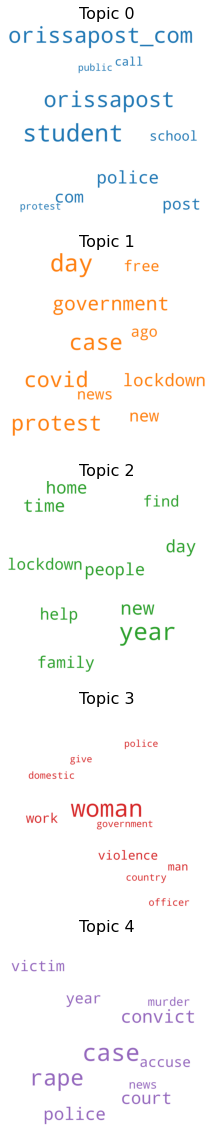

In [113]:
topics_nmf = nmf.show_topics(formatted=False)
fig, axes = plt.subplots(5, 1, figsize=(16,16), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics_nmf[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [114]:
nmf_dataset= news_text[(news_text['Topic_nmf']==3) | (news_text['Topic_nmf']==4)]

In [115]:
nmf_dataset.shape

(3395, 8)

In [119]:
nmf_lda = pd.concat([lda_dataset,nmf_dataset], axis=1)

In [120]:
nmf_lda.shape

(4054, 15)

In [121]:
nmf_lda.to_csv("./en_interim_01_05_DV_IN_nmf_lda.csv")